<a href="https://colab.research.google.com/github/DAOresearch/cadcad/blob/main/cadcad_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install cadcad

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

### Initial conditions and parameters

In [3]:
initial_conditions = {
    'dao_members': 1,
    'nfts': 1
    }

params = {
    "dao_growth_rate": [1.0],
    "nft_creation_rate": [0.01],
    "dao_churn_rate": [1.0],
    "nft_zombie_rate": [0.03],
    "dt": [0.1] # Precision of the simulation. Lower is more accurate / slower
}

simulation_parameters = {
    'N': 7, # Number of runs
    'T': range(200), # Number of timesteps
    'M': params # System params (advanced)
}

### Policies

In [4]:
def p_join_dao(params, step, sL, s):
    dt = params['dt']
    dao_population = s['dao_members']
    nft_population = s['nfts']
    contribute_fraction = params['dao_growth_rate'] + np.random.random() * 0.0002
    new_contributions =  contribute_fraction * dao_population * nft_population * dt
    return {'add_to_dao_members': new_contributions}

def p_create_nft(params, step, sL, s):
  dt = params['dt']
  nft_population = s['nfts']
  nft_creation_fraction = params['nft_creation_rate'] + np.random.random() * 0.1
  new_nfts =  nft_creation_fraction * nft_population * dt
  return {'add_to_nft_library': new_nfts}

def p_dao_member_churn(params, step, sL, s):
  dt = params['dt']
  dao_population = s['dao_members']
  churn_rate = params['dao_churn_rate'] + np.random.random() * 0.005
  churn = churn_rate * dao_population * dt
  return {'add_to_dao_members': -1.0 * churn}

### State Update Functions


In [5]:
def s_nft_library(params, step, sL, s, _input):
    y = 'nfts'
    x = s['nfts'] + _input['add_to_nft_library']
    return (y, x)

def s_dao_members(params, step, sL, s, _input):
    y = 'dao_members'
    x = s['dao_members'] + _input['add_to_dao_members']
    return (y, x)

### State Update Blocks

In [6]:
partial_state_update_blocks = [
    { 
        'policies': {
            'join_dao': p_join_dao,
            'create_nft': p_create_nft,
            'dao_member_churn': p_dao_member_churn,
        },
        'variables': {
            'dao_members': s_dao_members,
            'nfts': s_nft_library
        }
    }
]

### Configuration and Execution

In [7]:
sim_config = config_sim(simulation_parameters)

exp = Experiment()
exp.append_configs(sim_configs=sim_config, 
                   initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks)


from cadCAD import configs
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context=exec_context, configs=configs) 
(records, tensor_field, _) = executor.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (200, 5, 7, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.13s


In [8]:
import plotly.express as px

In [9]:
df = pd.DataFrame(records)

fig = px.line(df,
              x=df.nfts,
              y=df.dao_members,
              color=df.run.astype(str))

fig.show()

In [10]:
%%capture
!pip install cadCAD_diagram==0.0.1.2

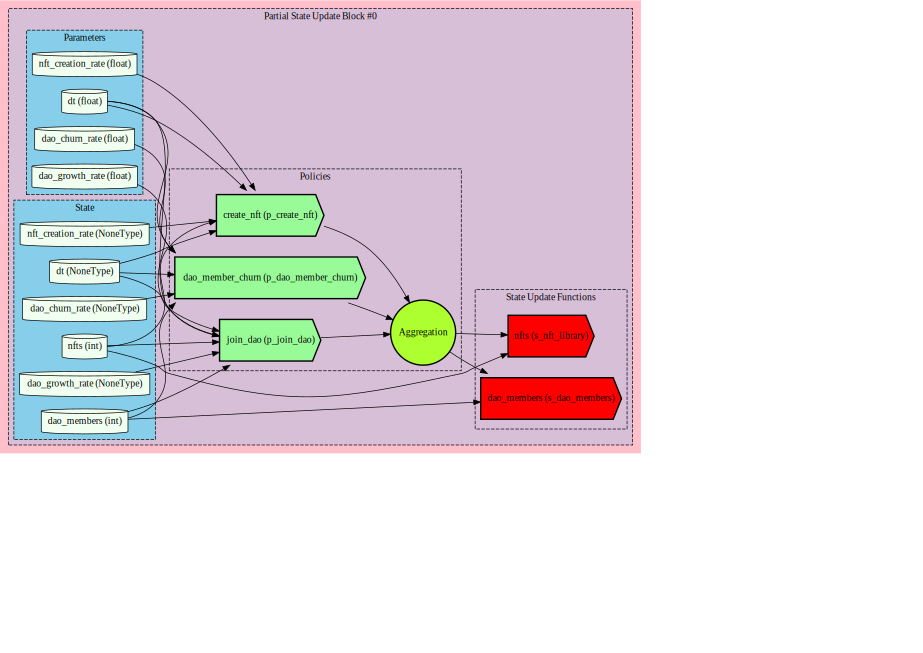

In [11]:
from cadCAD_diagram import diagram_from_config
from cadCAD import configs
diagram_from_config(configs[0])